<figure>
<img src="../Imagenes/logo-final-ap.png"  width="80" height="80" align="left"/> 
</figure>

# <span style="color:blue"><left>Aprendizaje Profundo</left></span>

# <span style="color:red"><center>Autoencoder para colorear imagenes</center></span>

**<center>Convolucional autoencoder</center>**

##   <span style="color:blue">Profesores</span>

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 
3. Campo Elías Pardo Turriago, cepardot@unal.edu.co 

##   <span style="color:blue">Asesora Medios y Marketing digital</span>
 

4. Maria del Pilar Montenegro, pmontenegro88@gmail.com 

## <span style="color:blue">Asistentes</span>

5. Oleg Jarma, ojarmam@unal.edu.co 
6. Laura Lizarazo, ljlizarazore@unal.edu.co 

## <span style="color:blue">Referencias</span>

1. Basadado en Rowel Atieza, [Advanced Deep Learning with TensorFlow 2 and Keras](https://www.amazon.com/-/es/Rowel-Atienza-ebook/dp/B0851D5YQQ), 2020.

## <span style="color:blue">Contenido</span>

* [Introducción](#Introducción)
* [Importa módulos](#Importa-módulos)
* [ Función para convertir una imagen a color en tonos de gris](#Función-para-convertir-una-imagen-a-color-en-tonos-de-gris)
* [Los datos](#Los-datos)
* [Configuración](#Configuración)
* [Encoder](#Encoder)
* [Decoder](#Decoder)
* [Autoencoder](#Autoencoder)
* [Callbacks](#Callbacks)
* [Compila](#Compila)
* [Entrena](#Entrena)
* [Predicciones y gráficas](#Predicciones-y-gráficas)

## <span style="color:blue">Introducción </span>

Construimos un autoencoder para colorear imágenes en tonos de grises

## <span style="color:blue">Importa módulos </span>

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os
  
from tensorflow.keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint 
from tensorflow.keras.datasets import cifar100 
from tensorflow.keras.utils import plot_model

## <span style="color:blue">Función para convertir una imagen a color en tonos de gris </span>

Para convertir una imagen a color a blanco y negro, debes realizar una operación llamada "desaturación" o "escala de grises". En esta operación, se calcula un único valor de luminosidad para cada píxel de la imagen, combinando las intensidades de los canales de color rojo, verde y azul.

Existen varias fórmulas para realizar esta conversión, pero una opción común es utilizar la siguiente fórmula:

`Valor de gris = (0.2989 * Canal Rojo) + (0.5870 * Canal Verde) + (0.1140 * Canal Azul)`

Donde "Canal Rojo", "Canal Verde" y "Canal Azul" representan los valores de intensidad en los respectivos canales de color de cada píxel.

Aplicando esta fórmula a cada píxel de la imagen, obtendrás una versión en blanco y negro de la misma, donde cada píxel tiene un solo valor que representa su luminosidad.

In [2]:
def rgb_2_gray(image): 
    return np.dot(image[..., :3], [0.2989, 0.5870, 0.1140]) 

## <span style="color:blue">Los datos</span>

Los datos son de la base [Cifar](https://www.cs.toronto.edu/~kriz/cifar.html) creados en la Universidad de Toronto.

### Lee datos

In [3]:
(x_train, _), (x_test, _) = cifar100.load_data() 
print(x_train.shape)
print(x_test.shape)

169001437/169001437 [==============================] - 6s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


### Crea imágenes en escala de grises

In [4]:
x_train_gray = x_train[..., :3]@[0.2989, 0.5870, 0.1140]
x_test_gray  = x_test[..., :3]@[0.2989, 0.5870, 0.1140]

# Reshape to the model
x_train_gray = np.expand_dims(x_train_gray , axis=3)
x_test_gray = np.expand_dims(x_test_gray, axis=3)

print(x_train_gray.shape)
print(x_test_gray.shape)

(50000, 32, 32, 1)
(10000, 32, 32, 1)


### Normaliza datos

In [5]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
  
x_train_gray = x_train_gray.astype('float32') / 255.
x_test_gray = x_test_gray.astype('float32') / 255.

## <span style="color:blue">Configuración</span>

In [6]:
rows = x_train.shape[1]
cols = x_train.shape[2]
channels = x_train.shape[3]

input_shape = (rows, cols, 1) 
batch_size = 256
kernel_size = 3
latent_dim = 512
layer_filters = [64, 128, 256] 
dropout_rate = 0.2

## <span style="color:blue">Encoder</span>

In [7]:
inputs = Input(shape = input_shape) 
x = inputs 
for filters in layer_filters: 
    x = Conv2D(filters = filters, 
               kernel_size = kernel_size, 
               strides = 2, 
               activation ='relu', 
               padding ='same')(x) 
    x = Dropout(dropout_rate)(x)
# Save the shape to the decoder
shape = x.shape.as_list()
# shape = shape[1:]

x = Flatten()(x) 
x = Dropout(dropout_rate)(x)
latent = Dense(latent_dim, name ='latent_vector')(x) 
encoder_colorizing = Model(inputs, latent, name ='encoder_colorizing') 

### Summary

Model: "encoder_colorizing"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        640       
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 256)  

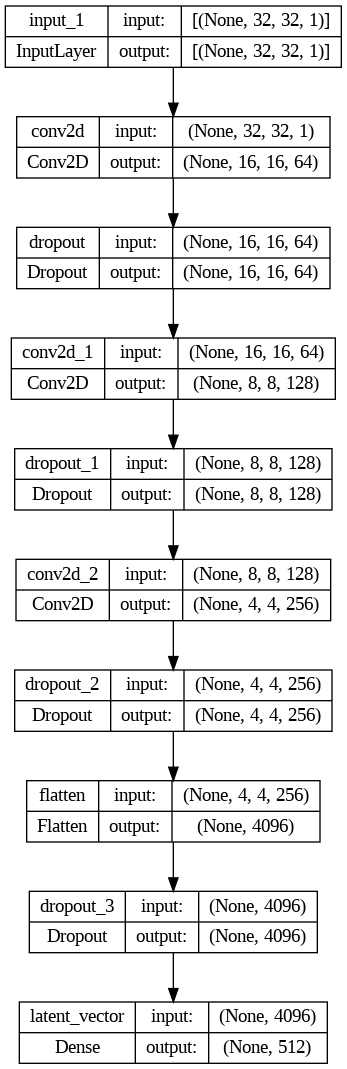

In [8]:
encoder_colorizing.summary()
plot_model(encoder_colorizing, to_file='./encoder_colorizing.png',show_shapes=True)

## <span style="color:blue">Decoder</span>

In [9]:
latent_inputs = Input(shape =(latent_dim, ), name ='decoder_input') 
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs) 
x = Reshape((shape[1], shape[2], shape[3]))(x) 
# stack of Conv2DTranspose(256)-Conv2DTranspose(128)- 
# Conv2DTranspose(64) 
for filters in layer_filters[::-1]: 
    x = Conv2DTranspose(filters = filters, 
                        kernel_size = kernel_size, 
                        strides = 2, 
                        activation ='relu', 
                        padding ='same')(x)
    x = Dropout(dropout_rate)(x)

outputs = Conv2DTranspose(filters = channels , 
                          kernel_size = kernel_size, 
                          activation ='sigmoid', 
                          padding ='same', 
                          name ='decoder_output')(x)
x = Dropout(dropout_rate)(x)
decoder_colorizing = Model(latent_inputs, outputs, name ='decoder_colorizing') 

In [10]:
for filters in layer_filters: 
  x = Conv2D(filters = filters, 
           kernel_size = kernel_size, 
           strides = 2, 
           activation ='relu', 
           padding ='same')(x) 

### Summary

Model: "decoder_colorizing"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 512)]             0         
                                                                 
 dense (Dense)               (None, 4096)              2101248   
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        590080    
 nspose)                                                         
                                                                 
 dropout_4 (Dropout)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      295040    
 ranspose)                                      

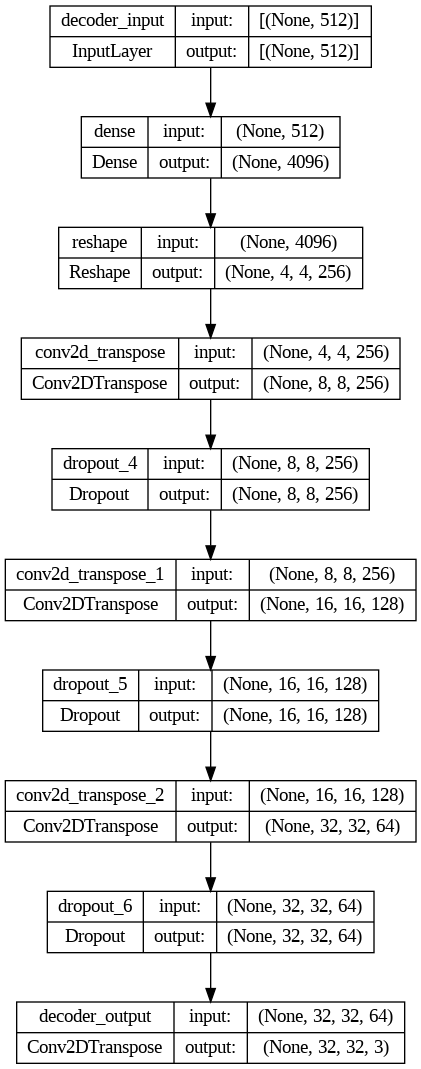

In [11]:
decoder_colorizing.summary()
plot_model(decoder_colorizing, to_file='./decoder_colorizing.png',show_shapes=True)

## <span style="color:blue">Autocoder</span>

In [12]:
autoencoder_colorizing = Model(inputs, decoder_colorizing(encoder_colorizing(inputs)), 
                    name ='autoencoder_colorizing') 

### Summary

Model: "autoencoder_colorizing"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 encoder_colorizing (Functio  (None, 512)              2467328   
 nal)                                                            
                                                                 
 decoder_colorizing (Functio  (None, 32, 32, 3)        3061891   
 nal)                                                            
                                                                 
Total params: 5,529,219
Trainable params: 5,529,219
Non-trainable params: 0
_________________________________________________________________


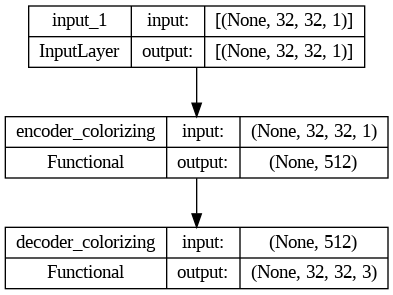

In [13]:
autoencoder_colorizing.summary()
plot_model(autoencoder_colorizing, to_file='./autoencoder_colorizing.png',show_shapes=True)

## <span style="color:blue">Callbacks</span>

In [14]:
# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), '../saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)


# called every epoch
callbacks = [lr_reducer, checkpoint]

## <span style="color:blue">Compila</span>

In [15]:
autoencoder_colorizing.compile(loss= 'mse',
                  optimizer= 'adam',
                   metrics=['mae'])

## <span style="color:blue">Entrena</span>

autoencoder_colorizing.fit(x_train_gray, 
                x_train, 
                validation_data =(x_test_gray, x_test), 
                epochs = epochs, 
                batch_size = batch_size) 

In [16]:
epochs = 20

history=autoencoder_colorizing.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks)

Epoch 1/20
196/196 [==============================] - ETA: 0s - loss: 0.0329 - mae: 0.1385
Epoch 1: val_loss improved from inf to 0.01935, saving model to /content/../saved_models/colorized_ae_model.001.h5
196/196 [==============================] - 30s 80ms/step - loss: 0.0329 - mae: 0.1385 - val_loss: 0.0193 - val_mae: 0.1027 - lr: 0.0010
Epoch 2/20
195/196 [============================>.] - ETA: 0s - loss: 0.0186 - mae: 0.1006
Epoch 2: val_loss improved from 0.01935 to 0.01635, saving model to /content/../saved_models/colorized_ae_model.002.h5
196/196 [==============================] - 14s 73ms/step - loss: 0.0185 - mae: 0.1006 - val_loss: 0.0164 - val_mae: 0.0927 - lr: 0.0010
Epoch 3/20
195/196 [============================>.] - ETA: 0s - loss: 0.0165 - mae: 0.0938
Epoch 3: val_loss improved from 0.01635 to 0.01461, saving model to /content/../saved_models/colorized_ae_model.003.h5
196/196 [==============================] - 14s 73ms/step - loss: 0.0165 - mae: 0.0938 - val_loss: 0.01

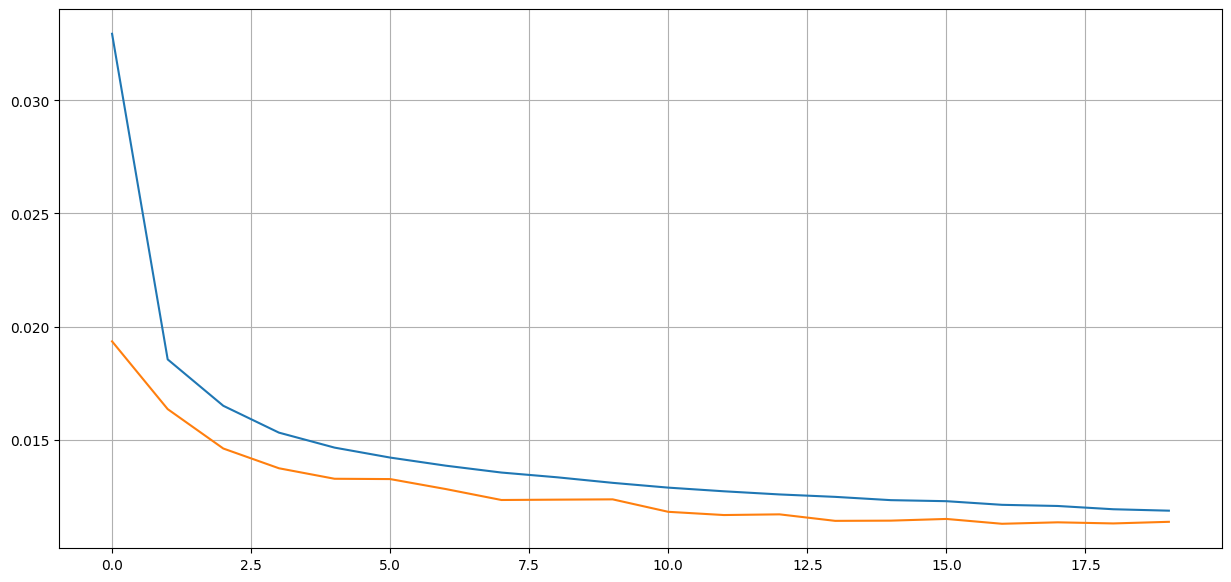

In [17]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.show()

## <span style="color:blue">Predicciones y gráficas</span>

In [18]:
x_decoded = autoencoder_colorizing.predict(x_test_gray)

313/313 [==============================] - 1s 3ms/step


### Imágenes originales

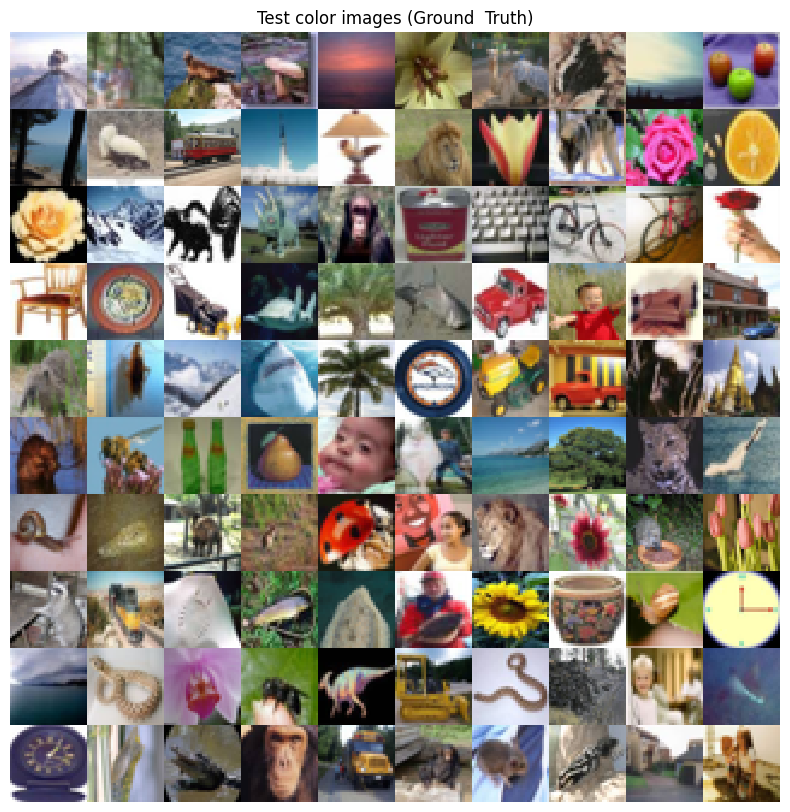

In [19]:
# display the 1st 100 input images (color and gray)

img_rows = rows
img_cols = cols

imgs_t = x_test[:100]
imgs_t = imgs_t.reshape((10, 10, img_rows, img_cols, channels))
imgs_t = np.vstack([np.hstack(i) for i in imgs_t])
plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs_t, interpolation='none')
plt.savefig('./test_color.png')
plt.show()

### Imágenes en escala de grises

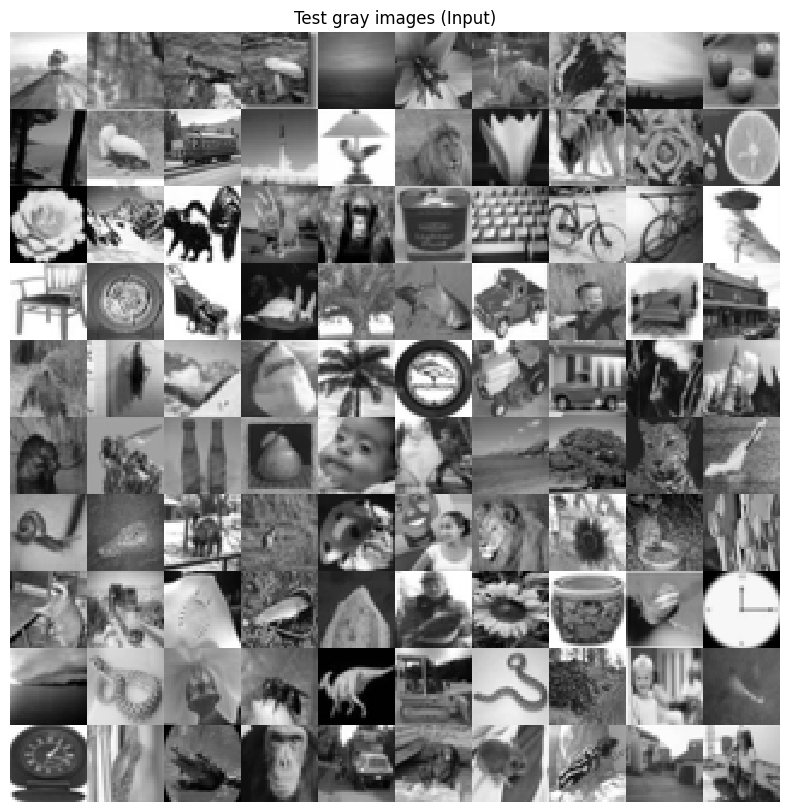

In [20]:
# display grayscale version of test images
imgs_g = x_test_gray[:100]
imgs_g = imgs_g.reshape((10, 10, img_rows, img_cols))
imgs_g = np.vstack([np.hstack(i) for i in imgs_g])
plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs_g, interpolation='none', cmap='gray')
plt.savefig('./test_gray.png')
plt.show()

### Primeras 100 imágenes coloreadas

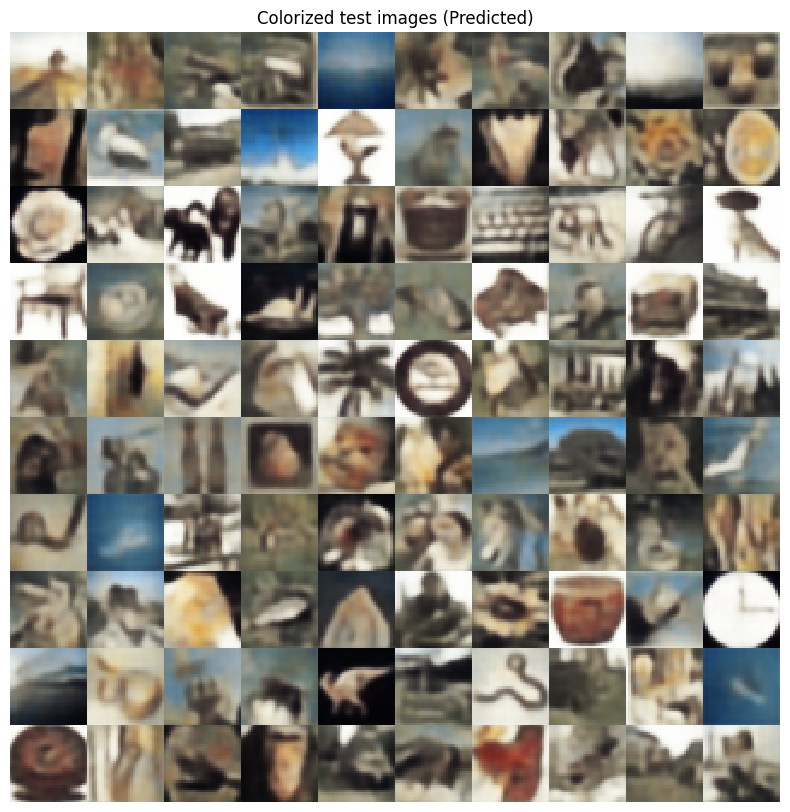

In [21]:
# display the 1st 100 colorized images
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('./colorized.png')

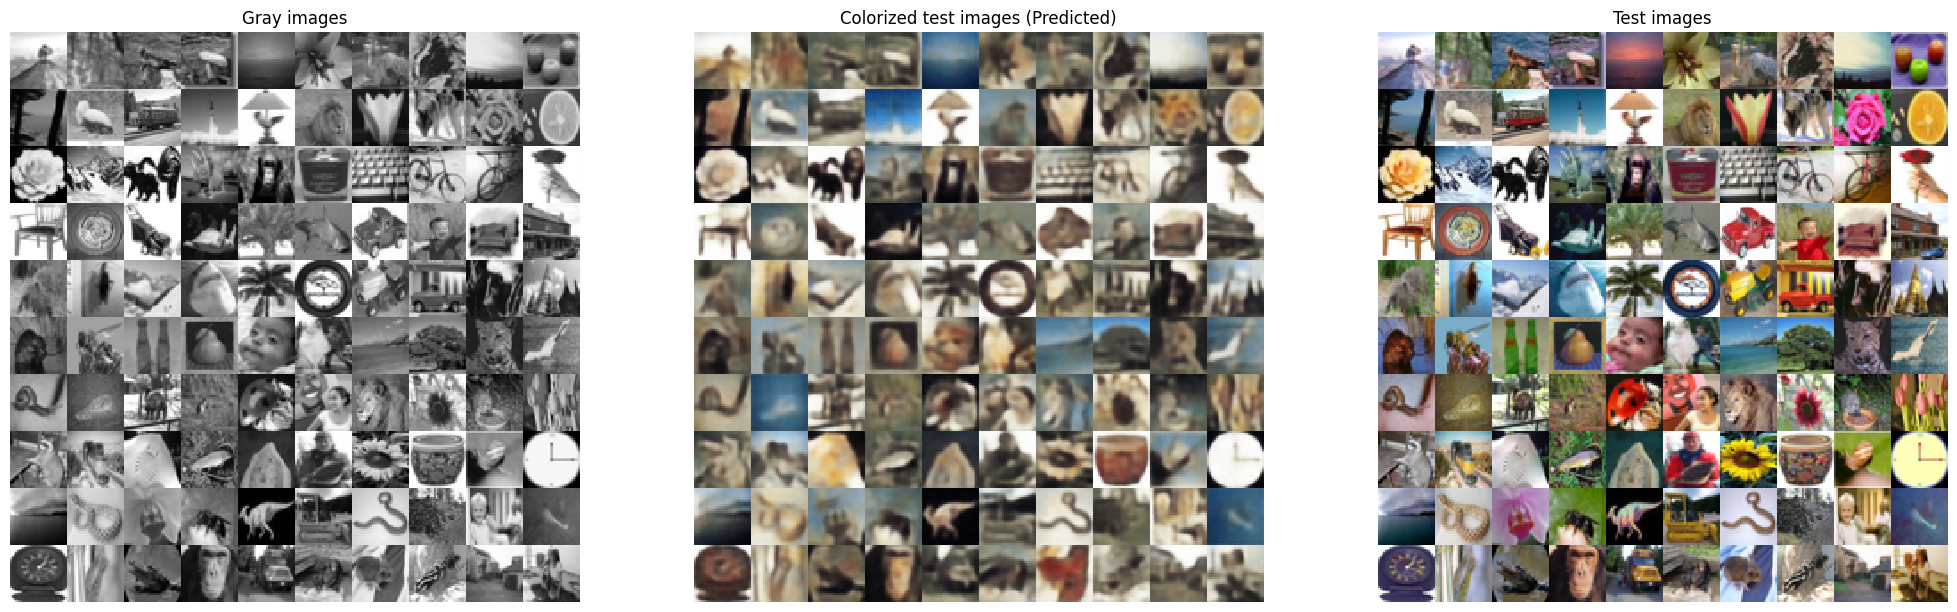

In [22]:
plt.figure(figsize=(25,25))
plt.subplot(131)
plt.axis('off')
plt.title('Gray images')
plt.imshow(imgs_g, interpolation='none',cmap='gray')
plt.savefig('./test.png')

plt.subplot(132)
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('./colorized.png')

plt.subplot(133)
plt.axis('off')
plt.title('Test images')
plt.imshow(imgs_t, interpolation='none')
plt.savefig('./test.png')

plt.show()